## PART 1: Data importing and cleaning

- Downloaded 5 years EOD data for AAPL, MSFT, SPY, and VIX
- Filled missing dates to align time series
- Removed outliers using rolling z-scores
- Scaled with standard scaling

In [49]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
import matplotlib.cm as cm
import feedparser
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
import scipy.cluster.hierarchy as sch
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer

tickers = ['AAPL', 'MSFT', 'SPY', '^VIX']

data = yf.download(tickers, period='5y', interval='1d')['Close']
data.ffill(inplace=True)
data.dropna(inplace=True)

data.head()

/var/folders/0f/l_wv06ws6k3063l3r6mv6xb80000gn/T/ipykernel_8265/245659955.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period='5y', interval='1d')['Close']
[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,MSFT,SPY,^VIX
Date,,,,
2020-08-12,109.926849,200.421951,314.196594,22.280001
2020-08-13,111.872284,199.952469,313.628448,22.129999
2020-08-14,111.772568,200.144073,313.637787,22.049999
2020-08-17,111.480751,201.466278,314.634125,21.350000
2020-08-18,112.409714,202.625549,315.313873,21.510000


In [6]:
for ticker in tickers:
    data[ticker] = data[ticker].ffill()

data.dropna()

Ticker,AAPL,MSFT,SPY,^VIX
Date,,,,
2020-08-12,109.926834,200.421921,314.196472,22.280001
2020-08-13,111.872269,199.952469,313.628479,22.129999
2020-08-14,111.772568,200.144058,313.637878,22.049999
2020-08-17,111.480751,201.466263,314.634125,21.350000
2020-08-18,112.409698,202.625580,315.313843,21.510000
...,...,...,...,...
2025-08-06,213.008255,524.940002,632.780029,16.770000
2025-08-07,219.780563,520.840027,632.250000,16.570000
2025-08-08,229.090012,522.039978,637.179993,15.150000


In [7]:
def remove_outliers_rolling_zscore(df, window=30, threshold=10):
    df_clean = df.copy()
    rolling_mean = df.rolling(window).mean()
    rolling_std = df.rolling(window).std()
    z_scores = (df - rolling_mean) / rolling_std
    df_clean = df.where(z_scores.abs() <= threshold)
    df_clean.ffill(inplace=True)
    return df_clean

clean_close = remove_outliers_rolling_zscore(data)

print(clean_close)

Ticker            AAPL        MSFT         SPY   ^VIX
Date                                                 
2020-08-12         NaN         NaN         NaN    NaN
2020-08-13         NaN         NaN         NaN    NaN
2020-08-14         NaN         NaN         NaN    NaN
2020-08-17         NaN         NaN         NaN    NaN
2020-08-18         NaN         NaN         NaN    NaN
...                ...         ...         ...    ...
2025-08-06  213.008255  524.940002  632.780029  16.77
2025-08-07  219.780563  520.840027  632.250000  16.57
2025-08-08  229.090012  522.039978  637.179993  15.15
2025-08-11  227.179993  521.770020  635.919983  16.25
2025-08-12  228.899994  525.010010  639.229980  15.60

[1256 rows x 4 columns]


In [8]:
scalers = {}
scaled_close = pd.DataFrame(index=clean_close.index)

for ticker in tickers:
    scaler = StandardScaler()
    scaled_col = scaler.fit_transform(clean_close[[ticker]])
    scaled_close[ticker] = scaled_col.flatten()
    scalers[ticker] = scaler

scaled_close

,AAPL,MSFT,SPY,^VIX
Date,,,,
2020-08-12,NaN,NaN,NaN,NaN
2020-08-13,NaN,NaN,NaN,NaN
2020-08-14,NaN,NaN,NaN,NaN
2020-08-17,NaN,NaN,NaN,NaN
2020-08-18,NaN,NaN,NaN,NaN
...,...,...,...,...
2025-08-06,1.212293,2.448113,2.219073,-0.564059
2025-08-07,1.402573,2.398359,2.212682,-0.600115
2025-08-08,1.664138,2.412921,2.272129,-0.856109


## Part 2: Feature engineering

- Created technical indicators and got features
- Labeled data on 5-day future returns direction
- Explored feature relationships with PCA
- Selected top 10 features

In [9]:
def SMA(series, window):
    return series.rolling(window).mean()

def EMA(series, window):
    return series.ewm(span=window, adjust=False).mean()

def RSI(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def Bollinger_Bands(series, window=20, num_std=2):
    sma = series.rolling(window).mean()
    std = series.rolling(window).std()
    upper = sma + (num_std * std)
    lower = sma - (num_std * std)
    return upper, lower

def MACD(series, fast=12, slow=26, signal=9):
    ema_fast = EMA(series, fast)
    ema_slow = EMA(series, slow)
    macd = ema_fast - ema_slow
    signal_line = EMA(macd, signal)
    hist = macd - signal_line
    return macd, signal_line, hist

In [56]:

df = clean_close[['AAPL']].copy()

df['SMA_20'] = SMA(df['AAPL'], 20)
df['EMA_20'] = EMA(df['AAPL'], 20)
df['RSI_14'] = RSI(df['AAPL'])
df['BB_upper'], df['BB_lower'] = Bollinger_Bands(df['AAPL'])
df['MACD'], df['MACD_signal'], df['MACD_hist'] = MACD(df['AAPL'])

df['Return_1d'] = df['AAPL'].pct_change(1)
df['Return_5d'] = df['AAPL'].pct_change(5)
df['Return_10d'] = df['AAPL'].pct_change(10)

df['Momentum_1d'] = df['AAPL'] - df['AAPL'].shift(1)
df['Momentum_5d'] = df['AAPL'] - df['AAPL'].shift(5)
df['Momentum_10d'] = df['AAPL'] - df['AAPL'].shift(10)

df.dropna(inplace=True)

display(df.head())

# to save:
#df.to_csv('output.csv', index=False)

Ticker,AAPL,SMA_20,EMA_20,RSI_14,BB_upper,BB_lower,MACD,MACD_signal,MACD_hist,Return_1d,Return_5d,Return_10d,Momentum_1d,Momentum_5d,Momentum_10d
Date,,,,,,,,,,,,,,,
2020-10-20,114.304062,112.780793,112.848918,52.563308,120.957995,104.603591,2.526094,2.664306,-0.138212,0.013192,-0.029645,0.038441,1.488243,-3.492050,4.231308
2020-10-21,113.681519,113.254991,112.928213,50.121869,120.367004,106.142978,2.283982,2.588241,-0.304259,-0.005446,-0.035647,0.015554,-0.622543,-4.202148,1.741150
2020-10-22,112.592102,113.621220,112.896202,54.524383,119.677372,107.565068,1.981360,2.466865,-0.485505,-0.009583,-0.041090,0.006784,-1.089417,-4.824661,0.758728
2020-10-23,111.901466,113.755457,112.801466,47.335779,119.512162,107.998751,1.666590,2.306810,-0.640220,-0.006134,-0.033440,-0.016500,-0.690636,-3.871407,-1.877319
2020-10-26,111.911201,113.759835,112.716679,53.926079,119.510484,108.009186,1.401760,2.125800,-0.724040,0.000087,-0.008019,-0.075161,0.009735,-0.904617,-9.094887


In [11]:
df['Future_Close_5d'] = df['AAPL'].shift(-5)
df['Target'] = (df['Future_Close_5d'] > df['AAPL']).astype(int)
df.dropna(subset=['Target'], inplace=True)

df[['AAPL', 'Future_Close_5d', 'Target']]

Ticker,AAPL,Future_Close_5d,Target
Date,,,
2020-10-20,114.304062,113.418892,0
2020-10-21,113.681519,108.166214,0
2020-10-22,112.592102,112.173820,0
2020-10-23,111.901466,105.890060,0
2020-10-26,111.911201,105.802513,0
...,...,...,...
2025-08-06,213.008255,NaN,0
2025-08-07,219.780563,NaN,0
2025-08-08,229.090012,NaN,0


In [12]:
features = ['SMA_20', 'EMA_20', 'RSI_14', 'BB_upper', 'BB_lower',
            'MACD', 'MACD_signal', 'MACD_hist',
            'Return_1d', 'Return_5d', 'Return_10d',
            'Momentum_1d', 'Momentum_5d', 'Momentum_10d']

X = df[features]
y = df['Target']

X.head(), y.head()

(Ticker          SMA_20      EMA_20     RSI_14    BB_upper    BB_lower  \
 Date                                                                    
 2020-10-20  112.780793  112.848918  52.563308  120.957995  104.603591   
 2020-10-21  113.254991  112.928213  50.121869  120.367004  106.142978   
 2020-10-22  113.621220  112.896202  54.524383  119.677372  107.565068   
 2020-10-23  113.755457  112.801466  47.335779  119.512162  107.998751   
 2020-10-26  113.759835  112.716679  53.926079  119.510484  108.009186   
 
 Ticker          MACD  MACD_signal  MACD_hist  Return_1d  Return_5d  \
 Date                                                                 
 2020-10-20  2.526094     2.664306  -0.138212   0.013192  -0.029645   
 2020-10-21  2.283982     2.588241  -0.304259  -0.005446  -0.035647   
 2020-10-22  1.981360     2.466865  -0.485505  -0.009583  -0.041090   
 2020-10-23  1.666590     2.306810  -0.640220  -0.006134  -0.033440   
 2020-10-26  1.401760     2.125800  -0.724040   0.0000

## PART 3: Training ML model

- Training metrics being significantly better than test metrics would suggest overfitting.
- Walk-forward validation avoids look-ahead bias and simulates real-time performance.
- Feature lagging ensures no future info leaks into predictions.
- Consider hyperparameter tuning to reduce overfitting.

In [50]:
window_size = 200
test_size = 50
X_lagged = X.shift(1).dropna()
y_aligned = y.loc[X_lagged.index]

predictions = {
    'LinearRegression': [],
    'RandomForestRegressor': [],
    'LogisticRegression': [],
    'DecisionTreeClassifier': []
}
true_vals = []

start = 0
end = window_size

dates = X_lagged.index

while end + test_size <= len(X_lagged):
    train_X = X_lagged.iloc[start:end]
    train_y = y_aligned.iloc[start:end]
    test_X = X_lagged.iloc[end:end+test_size]
    test_y = y_aligned.iloc[end:end+test_size]
    true_vals.extend(test_y)

    # LR
    lr = LinearRegression()
    lr.fit(train_X, train_y)
    pred_lr = lr.predict(test_X)
    predictions['LinearRegression'].extend(pred_lr)

    # RF
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(train_X, train_y)
    pred_rf = rf.predict(test_X)
    predictions['RandomForestRegressor'].extend(pred_rf)

    # LogR
    logr = LogisticRegression(max_iter=1000)
    logr.fit(train_X, train_y)
    pred_logr = logr.predict(test_X)
    predictions['LogisticRegression'].extend(pred_logr)

    # DT
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(train_X, train_y)
    pred_dt = dt.predict(test_X)
    predictions['DecisionTreeClassifier'].extend(pred_dt)
    
    start += test_size
    end += test_size


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


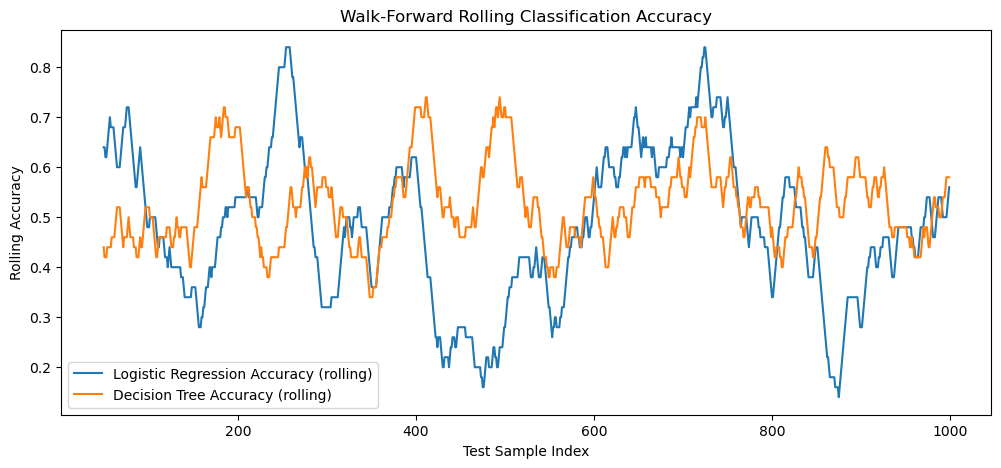

In [15]:
window_plot = 50  # rolling window for metric

acc_logr = pd.Series(pred_logr == true_vals).rolling(window_plot).mean()
acc_dt = pd.Series(pred_dt == true_vals).rolling(window_plot).mean()

plt.figure(figsize=(12,5))
plt.plot(acc_logr, label='Logistic Regression Accuracy (rolling)')
plt.plot(acc_dt, label='Decision Tree Accuracy (rolling)')
plt.xlabel('Test Sample Index')
plt.ylabel('Rolling Accuracy')
plt.title('Walk-Forward Rolling Classification Accuracy')
plt.legend()
plt.show()

## PART 4: Model Evaluation

In [52]:
true_vals = np.array(true_vals)
pred_lr = np.array(predictions['LinearRegression'])
pred_rf = np.array(predictions['RandomForestRegressor'])
pred_logr = np.array(predictions['LogisticRegression'])
pred_dt = np.array(predictions['DecisionTreeClassifier'])

print("LR R^2:", r2_score(true_vals, pred_lr))
print("LR RMSE:", np.sqrt(mean_squared_error(true_vals, pred_lr)))

print("RF R^2:", r2_score(true_vals, pred_rf))
print("RF RMSE:", np.sqrt(mean_squared_error(true_vals, pred_rf)))

print("LogR Accuracy:", accuracy_score(true_vals, pred_logr))
print("LogR F1:", f1_score(true_vals, pred_logr))

print("DT Accuracy:", accuracy_score(true_vals, pred_dt))
print("DT F1:", f1_score(true_vals, pred_dt))

Linear Regression R^2: -1.0095792785779905
Linear Regression RMSE: 0.7066386980358353
Random Forest Regression R^2: -0.18715022195034625
Random Forest Regression RMSE: 0.5431223619038347
Logistic Regression Accuracy: 0.485
Logistic Regression F1: 0.5478489903424056
Decision Tree Accuracy: 0.527
Decision Tree F1: 0.5525070955534532


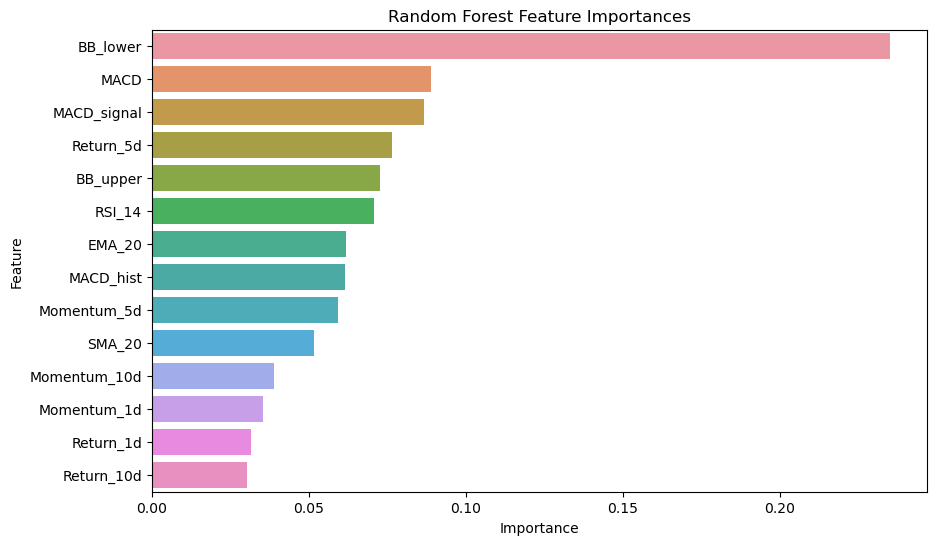

In [53]:
importances = rf.feature_importances_
feature_names = X_lagged.columns

fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=fi_df)
plt.title('Random Forest Feature Importances')
plt.show()

## PART 5: Clustering

**Source for markdown: Internet search for clustering techniques, I was not particularly familiar with them.**

- Silhouette scores indicate the chosen number of clusters captures meaningful groupings, but further tuning may improve separation.
- Dendrogram shows hierarchical relationships and potential for sub-cluster identification.

In [16]:
X_scaled = scaler.fit_transform(train_X)

k = 3

kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

sil_score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score for k={k}: {sil_score:.3f}")

Silhouette Score for k=3: 0.306


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


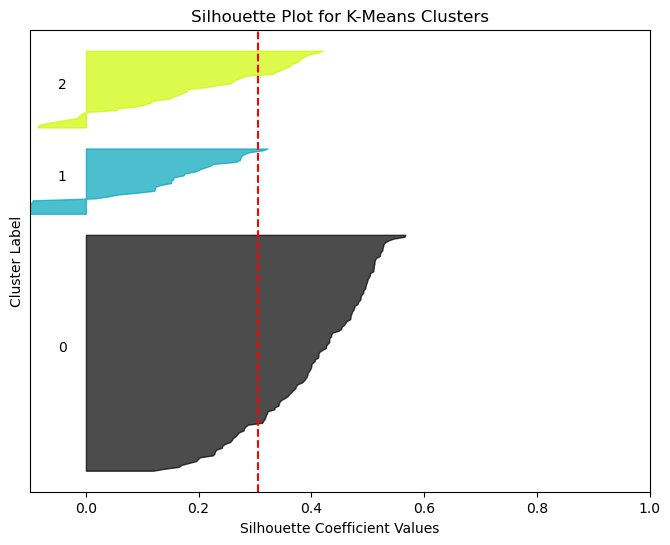

In [17]:
fig, ax1 = plt.subplots(figsize=(8,6))

sample_silhouette_values = silhouette_samples(X_scaled, clusters)
y_lower = 10
for i in range(k):
    ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1.set_title("Silhouette Plot for K-Means Clusters")
ax1.set_xlabel("Silhouette Coefficient Values")
ax1.set_ylabel("Cluster Label")
ax1.axvline(x=sil_score, color="red", linestyle="--")
ax1.set_yticks([])
ax1.set_xlim([-0.1, 1])
plt.show()

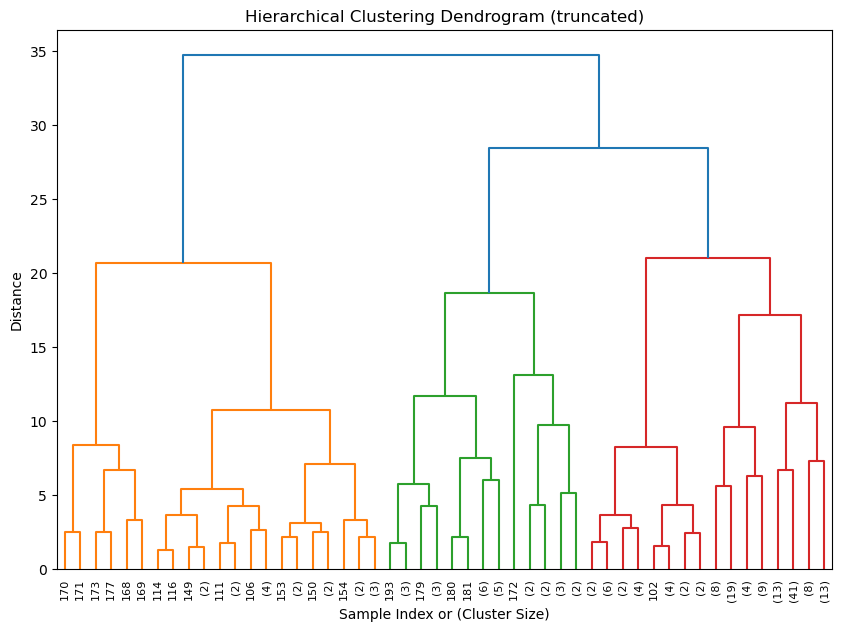

In [18]:

linked = sch.linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 7))
dendro = sch.dendrogram(linked, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.show()

## PART 6: NLP Sentiment

Price tends to move with nature of the news! - which seems contradictory to the results in the NLP quiz.

In [22]:
tickers = ['AAPL', 'SPY']
all_articles = []

for ticker in tickers:
    rss_url = f'https://news.google.com/rss/search?q={ticker}+when:7d&hl=en-US&gl=US&ceid=US:en'
    feed = feedparser.parse(rss_url)
    
    for entry in feed.entries:
        all_articles.append({
            'timestamp': entry.published,
            'ticker': ticker,
            'headline': entry.title,
            'source': entry.source.title if 'source' in entry else 'Google News'
        })

news_df = pd.DataFrame(all_articles)
news_df['timestamp'] = pd.to_datetime(news_df['timestamp'])
news_df['date'] = news_df['timestamp'].dt.date

print(f"Collected {len(news_df)} news headlines")
news_df.head()


Collected 200 news headlines


,timestamp,ticker,headline,source,date
0,2025-08-11 14:08:28,AAPL,Apple Inc (AAPL) Increases its Total Investmen...,Yahoo Finance,2025-08-11
1,2025-08-08 10:02:05,AAPL,"After Earnings, Is Apple Stock a Buy, a Sell, ...",Morningstar,2025-08-08
2,2025-08-06 14:46:00,AAPL,$AAPL stock is up 3% today. Here's what we see...,Quiver Quantitative,2025-08-06
3,2025-08-09 21:52:09,AAPL,Apple Stock (AAPL) Pops as Trump Vows 100% Tar...,TipRanks,2025-08-09
4,2025-08-06 23:02:00,AAPL,"Apple stock extends gains, rises 3% postmarket...",Seeking Alpha,2025-08-06


In [23]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(tokens)

news_df['clean_headline'] = news_df['headline'].astype(str).apply(preprocess_text)
news_df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shubhaankargupta/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shubhaankargupta/nltk_data...


,timestamp,ticker,headline,source,date,clean_headline
0,2025-08-11 14:08:28,AAPL,Apple Inc (AAPL) Increases its Total Investmen...,Yahoo Finance,2025-08-11,apple inc aapl increase total investment 600 b...
1,2025-08-08 10:02:05,AAPL,"After Earnings, Is Apple Stock a Buy, a Sell, ...",Morningstar,2025-08-08,earnings apple stock buy sell fairly valued mo...
2,2025-08-06 14:46:00,AAPL,$AAPL stock is up 3% today. Here's what we see...,Quiver Quantitative,2025-08-06,aapl stock 3 today here see data quiver quanti...
3,2025-08-09 21:52:09,AAPL,Apple Stock (AAPL) Pops as Trump Vows 100% Tar...,TipRanks,2025-08-09,apple stock aapl pop trump vow 100 tariff reli...
4,2025-08-06 23:02:00,AAPL,"Apple stock extends gains, rises 3% postmarket...",Seeking Alpha,2025-08-06,apple stock extends gain rise 3 postmarket con...


In [24]:


nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

news_df['sentiment_score'] = news_df['clean_headline'].apply(lambda x: sid.polarity_scores(x)['compound'])
news_df.head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shubhaankargupta/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,timestamp,ticker,headline,source,date,clean_headline,sentiment_score
0,2025-08-11 14:08:28,AAPL,Apple Inc (AAPL) Increases its Total Investmen...,Yahoo Finance,2025-08-11,apple inc aapl increase total investment 600 b...,0.7506
1,2025-08-08 10:02:05,AAPL,"After Earnings, Is Apple Stock a Buy, a Sell, ...",Morningstar,2025-08-08,earnings apple stock buy sell fairly valued mo...,0.4404
2,2025-08-06 14:46:00,AAPL,$AAPL stock is up 3% today. Here's what we see...,Quiver Quantitative,2025-08-06,aapl stock 3 today here see data quiver quanti...,0.0000
3,2025-08-09 21:52:09,AAPL,Apple Stock (AAPL) Pops as Trump Vows 100% Tar...,TipRanks,2025-08-09,apple stock aapl pop trump vow 100 tariff reli...,0.4767
4,2025-08-06 23:02:00,AAPL,"Apple stock extends gains, rises 3% postmarket...",Seeking Alpha,2025-08-06,apple stock extends gain rise 3 postmarket con...,0.5994


In [25]:
daily_sentiment = news_df.groupby(['date', 'ticker'])['sentiment_score'].mean().reset_index()
daily_sentiment.head()

,date,ticker,sentiment_score
0,2025-08-05,AAPL,-0.120400
1,2025-08-05,SPY,-0.120040
2,2025-08-06,AAPL,0.147259
3,2025-08-06,SPY,-0.163194
4,2025-08-07,AAPL,0.055640


In [39]:
market_df = clean_close[['AAPL']].reset_index().rename(columns={'Date': 'date', 'AAPL': 'close'})
sent_aapl = daily_sentiment[daily_sentiment['ticker']=='AAPL'][['date', 'sentiment_score']]
market_df['date'] = pd.to_datetime(market_df['date'])
sent_aapl['date'] = pd.to_datetime(sent_aapl['date'])

merged_df = pd.merge(market_df, sent_aapl, on='date', how='left')

merged_df['sentiment_score'].fillna(method='ffill', inplace=True)

merged_df.tail()

/var/folders/0f/l_wv06ws6k3063l3r6mv6xb80000gn/T/ipykernel_8265/2557188174.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['sentiment_score'].fillna(method='ffill', inplace=True)
/var/folders/0f/l_wv06ws6k3063l3r6mv6xb80000gn/T/ipykernel_8265/2557188174.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['sentiment_score'].fillna(method='ffill', inplace=True)
/var/folders/0f/l_wv06ws6k3063l3r6mv6xb80000gn/T/ipyker

,date,close,sentiment_score
1251,2025-08-06,213.008255,0.147259
1252,2025-08-07,219.780563,0.055640
1253,2025-08-08,229.090012,0.141709
1254,2025-08-11,227.179993,0.167882
1255,2025-08-12,228.899994,-0.216200


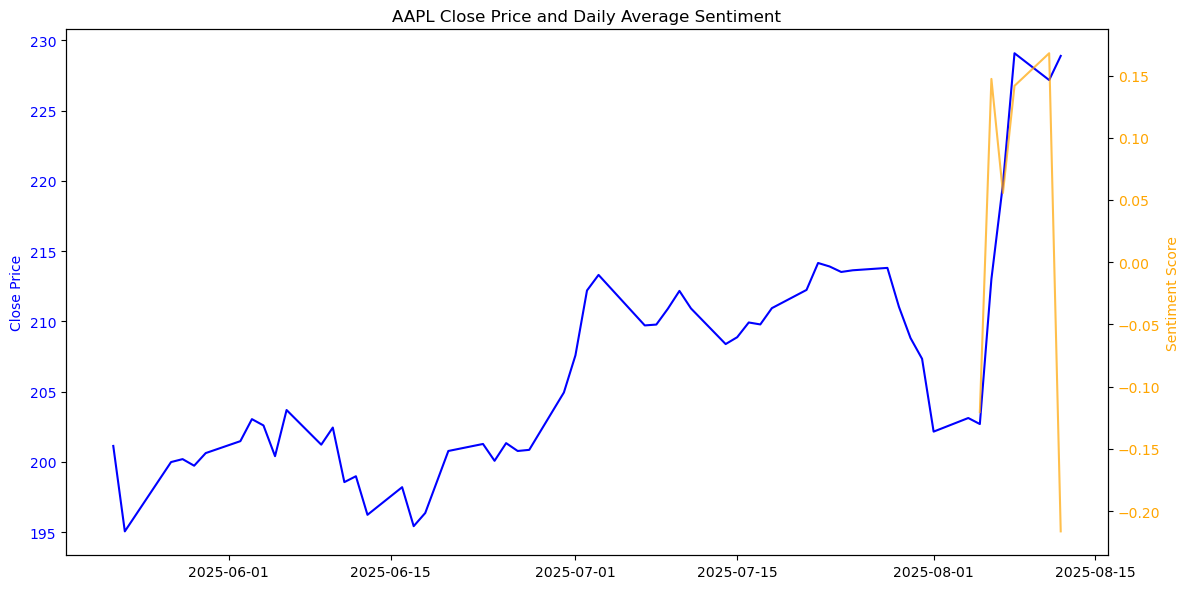

In [44]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(merged_df['date'][1200::], merged_df['close'][1200::], color='blue', label='AAPL Close Price')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(merged_df['date'], merged_df['sentiment_score'], color='orange', label='Sentiment Score', alpha=0.7)
ax2.set_ylabel('Sentiment Score', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('AAPL Close Price and Daily Average Sentiment')
fig.tight_layout()
plt.show()